# Statistical tests for "Silicone: an open-source Python package for inferring missing emissions data for climate change research"
This notebook is where results that require exploration of the data outside of the silicone package were calculated. The results that go into this notebook were derived by running the script `scripts/compare_crunchers.py`. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from itertools import combinations

In [2]:
CO2_results_orig = pd.read_csv("../input/CruncherComparisonLead_stdv_CO2.csv", index_col=0)
CH4_results_orig = pd.read_csv("../input/CruncherComparisonLead_stdv_CH4.csv", index_col=0)

## Calculating the difference between infilling with CO2 and CH4 emissions
We can't compare the values with CO2 or CH4 itself, as they are only found in one of the two datasets, so we start by removing them. 

In [3]:
to_drop = ["Emissions|CO2", "Emissions|CH4"]
CO2_results = CO2_results_orig.drop(to_drop, errors="ignore")
CH4_results = CH4_results_orig.drop(to_drop, errors="ignore")

We can now calculate the difference

In [4]:
difference_res = (CO2_results - CH4_results)
difference_res

,TimeDepRatio,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,0.680653,0.005383,0.011394,0.049705,0.045927
Emissions|CO,0.825910,0.006286,0.122418,0.031960,-0.011376
Emissions|F-Gases,-0.082588,-0.028508,-0.020765,-0.038032,-0.061443
Emissions|HFC,-0.079501,-0.034051,0.040344,-0.063303,-0.067836
Emissions|N2O,0.846571,0.187562,0.170851,0.300584,0.344806
Emissions|NH3,0.546394,0.025537,0.142734,0.117625,0.012227
Emissions|NOx,0.619371,-0.018306,-0.018586,0.003653,0.012659
Emissions|OC,0.744116,0.014948,0.121464,0.097163,0.122549
Emissions|PFC,0.057638,0.030030,0.129166,0.050326,0.061806
Emissions|SF6,0.050492,0.020381,-0.002353,-0.005633,0.010008


We investigate these visually and using the Shapiro-Wilk test to check for normality.

([array([2., 2., 0., 1., 0., 0., 1., 1., 2., 3.]),
  array([7., 4., 1., 0., 0., 0., 0., 0., 0., 0.]),
  array([4., 3., 5., 0., 0., 0., 0., 0., 0., 0.]),
  array([4., 6., 1., 0., 1., 0., 0., 0., 0., 0.]),
  array([6., 4., 1., 0., 1., 0., 0., 0., 0., 0.])],
 array([-0.08258781,  0.01032808,  0.10324396,  0.19615985,  0.28907574,
         0.38199163,  0.47490751,  0.5678234 ,  0.66073929,  0.75365518,
         0.84657107]),
 <a list of 5 Lists of Patches objects>)

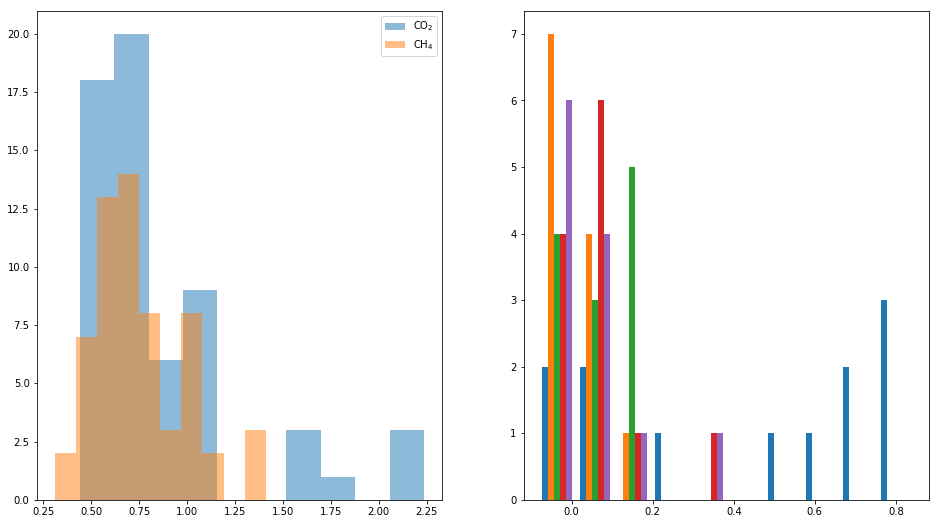

In [5]:
fig = plt.figure(figsize=(16, 9))
ax = plt.subplot(121)
plt.hist(CO2_results.values.ravel(), alpha = 0.5, label="CO$_2$")
plt.hist(CH4_results.values.ravel(), alpha = 0.5, label="CH$_4$")
ax.legend()
ax = plt.subplot(122)
plt.hist(difference_res.values)

In [6]:
for col in CO2_results:
    stat, pc = stats.shapiro(CO2_results[col])
    stat, pm = stats.shapiro(CH4_results[col])
    print("For {}, CO2 has p-value {} and CH4 has {}".format(col, pc, pm))
stat, pc = stats.shapiro(CO2_results.values)
stat, pm = stats.shapiro(CH4_results.values)
print("For all values together, CO2 has p-value {} and CH4 has {}".format(pc, pm))

For TimeDepRatio, CO2 has p-value 0.06285779923200607 and CH4 has 0.050111010670661926
For QuantileRollingWindows, CO2 has p-value 0.11986661702394485 and CH4 has 0.4318114221096039
For RMSClosest, CO2 has p-value 0.20779410004615784 and CH4 has 0.2776501178741455
For LinearInterpolation, CO2 has p-value 0.02942139096558094 and CH4 has 0.12278267741203308
For EqualQuantileWalk, CO2 has p-value 0.4230673015117645 and CH4 has 0.35340240597724915
For all values together, CO2 has p-value 1.0015436480159678e-08 and CH4 has 0.0032295917626470327


It is clear that these statistics violate normality as values << 0.05 are found. We will therefore use the Wilcoxon t-tests.

In [7]:
# Calculate the t-test statistics for each cruncher
for col in CO2_results.columns:
    print("For column {} we get result {}".format(col, stats.wilcoxon(CO2_results[col], CH4_results[col])))

For column TimeDepRatio we get result WilcoxonResult(statistic=7.0, pvalue=0.012063323418854825)
For column QuantileRollingWindows we get result WilcoxonResult(statistic=30.0, pvalue=0.480176889906077)
For column RMSClosest we get result WilcoxonResult(statistic=13.0, pvalue=0.041389404009149304)
For column LinearInterpolation we get result WilcoxonResult(statistic=15.0, pvalue=0.05973901545539241)
For column EqualQuantileWalk we get result WilcoxonResult(statistic=28.0, pvalue=0.38818640520827785)


In [8]:
# Calculate the t-test statistics for all data together
stats.wilcoxon(CO2_results.values.ravel(), CH4_results.values.ravel())

WilcoxonResult(statistic=376.0, pvalue=7.250752330598026e-05)

# Calculating the difference between crunchers
We can include the CH$_4$ and CO$_2$ results again now, as we are not doing pairwise comparison. 

In [9]:
all_results = CO2_results_orig.append(CH4_results_orig)
all_results

,TimeDepRatio,QuantileRollingWindows,RMSClosest,LinearInterpolation,EqualQuantileWalk
Emissions|BC,1.762679,0.733960,0.668365,1.021198,0.920502
Emissions|CH4,0.774296,0.460383,0.392151,0.520106,0.500427
Emissions|CO,2.236335,0.804163,0.764043,1.048605,1.006370
Emissions|F-Gases,0.576351,0.536862,0.484905,0.619424,0.602951
Emissions|HFC,0.617586,0.558599,0.511558,0.605727,0.581377
Emissions|N2O,1.565889,0.644774,0.534779,0.797249,0.785695
Emissions|NH3,1.680532,0.781498,0.675762,1.075981,1.060212
Emissions|NOx,1.538197,0.661548,0.605937,0.826352,0.771136
Emissions|OC,2.062032,0.791709,0.705881,1.068799,1.111797
Emissions|PFC,0.649296,0.575836,0.440812,0.599843,0.763535


Test for normality:

In [10]:
for col in all_results:
    print(stats.shapiro(all_results[col]))

(0.8575218915939331, 0.0019973914604634047)
(0.9216777086257935, 0.04923069477081299)
(0.9766243696212769, 0.7954659461975098)
(0.9038967490196228, 0.019150035455822945)
(0.9486953616142273, 0.21611006557941437)


In [11]:
stats.shapiro(all_results)

(0.792113721370697, 2.721388869461605e-12)

The individual cruncher results are again non-normal, necessitating Wilcoxon's test rather than a student t-test. We can now do pairwise comparisons of the crunchers: 

In [12]:
results_all = []
results_CO2 = []
results_CH4 = []
column_combo = combinations(all_results.columns, 2)
for col1, col2 in column_combo:
    results_all.append([col1, col2, stats.wilcoxon(all_results[col1], all_results[col2]).pvalue])
    results_CO2.append([col1, col2, stats.wilcoxon(CO2_results_orig[col1], CO2_results_orig[col2]).pvalue])
    results_CH4.append([col1, col2, stats.wilcoxon(CH4_results_orig[col1], CH4_results_orig[col2]).pvalue])

In [13]:
results_all

[['TimeDepRatio', 'QuantileRollingWindows', 8.29809930635731e-06],
 ['TimeDepRatio', 'RMSClosest', 8.29809930635731e-06],
 ['TimeDepRatio', 'LinearInterpolation', 9.67546354728976e-05],
 ['TimeDepRatio', 'EqualQuantileWalk', 0.0005266468058223855],
 ['QuantileRollingWindows', 'RMSClosest', 8.29809930635731e-06],
 ['QuantileRollingWindows', 'LinearInterpolation', 8.29809930635731e-06],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 1.050305306647201e-05],
 ['RMSClosest', 'LinearInterpolation', 8.29809930635731e-06],
 ['RMSClosest', 'EqualQuantileWalk', 8.29809930635731e-06],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.5337772019665354]]

In [14]:
results_CH4

[['TimeDepRatio', 'QuantileRollingWindows', 0.0014737808438751421],
 ['TimeDepRatio', 'RMSClosest', 0.0014737808438751421],
 ['TimeDepRatio', 'LinearInterpolation', 0.007132413699395206],
 ['TimeDepRatio', 'EqualQuantileWalk', 0.027707849358079864],
 ['QuantileRollingWindows', 'RMSClosest', 0.0014737808438751421],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0014737808438751421],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.0023655770533978757],
 ['RMSClosest', 'LinearInterpolation', 0.0014737808438751421],
 ['RMSClosest', 'EqualQuantileWalk', 0.0014737808438751421],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.7531523647659145]]

In [15]:
results_CO2

[['TimeDepRatio', 'QuantileRollingWindows', 0.0014737808438751421],
 ['TimeDepRatio', 'RMSClosest', 0.0014737808438751421],
 ['TimeDepRatio', 'LinearInterpolation', 0.0037285953227358883],
 ['TimeDepRatio', 'EqualQuantileWalk', 0.008774633060101173],
 ['QuantileRollingWindows', 'RMSClosest', 0.0014737808438751421],
 ['QuantileRollingWindows', 'LinearInterpolation', 0.0014737808438751421],
 ['QuantileRollingWindows', 'EqualQuantileWalk', 0.0014737808438751421],
 ['RMSClosest', 'LinearInterpolation', 0.0014737808438751421],
 ['RMSClosest', 'EqualQuantileWalk', 0.0014737808438751421],
 ['LinearInterpolation', 'EqualQuantileWalk', 0.2787073832496024]]

In [16]:
all_results.mean()

TimeDepRatio              1.120282
QuantileRollingWindows    0.652610
RMSClosest                0.548211
LinearInterpolation       0.795416
EqualQuantileWalk         0.794879
dtype: float64

We can see that there are statistically significantly different means between all the crunchers except LinearInterpolation and EQW for either lead gas or both together. 